## FnSpace 활용사례 - Markowitz 포트폴리오 기반 자산 배분

In [8]:
! pip install fnspace

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sco
import requests 
import time
from fnspace import FnSpace

api_key = 'Your API key'
fs = FnSpace(api_key)

## 데이터 로드 및 정렬

In [8]:
ticker_list = ["223190", "226980", "472350", "069500", "269420", "261220", "182480", "271050"]
# 주가 데이터 로드
df = fs.get_data(category="stock_price", 
                 code=ticker_list, 
                 item="S100300", # 수정종가만 load
                 from_date="20230101", 
                 to_date="20240601")

# 'DT' 컬럼 이름을 'Date'로 변경
df.rename(columns={'DT': 'Date', 'S100300': 'Price'}, inplace=True)

# CODE를 기준으로 피봇하여 새로운 데이터프레임 생성
data = df.pivot(index='Date', columns='CODE', values='Price')
data

CODE,A069500,A182480,A223190,A226980,A261220,A269420,A271050,A472350
Date,,,,,,,,
2022-12-29,28544.0,10899.0,8365.0,10755.0,14315.0,13455.0,4895.0,NaN
2023-01-02,28375.0,11007.0,8280.0,10504.0,14630.0,13295.0,4820.0,NaN
2023-01-03,28375.0,11044.0,8266.0,10470.0,14695.0,13385.0,4775.0,NaN
2023-01-04,28973.0,11152.0,8436.0,10475.0,14010.0,13535.0,5005.0,NaN
2023-01-05,29205.0,11362.0,8591.0,10480.0,13525.0,13540.0,5150.0,NaN
...,...,...,...,...,...,...,...,...
2024-05-27,37195.0,11636.0,11505.0,13970.0,15135.0,15830.0,4260.0,11810.0
2024-05-28,37235.0,11660.0,11490.0,13970.0,15280.0,15745.0,4220.0,11840.0
2024-05-29,36690.0,11442.0,11405.0,13865.0,15525.0,15810.0,4150.0,11635.0


## 클래스 정의

In [24]:
class MarkowitzPortfolio(object):
    def __init__(self, rets, rf=0.03, max_weight=0.3):
        self.rets = rets
        self.rf = rf
        self.max_weight = max_weight
        self.expected_return = rets.mean() * 252 # 연율화 포트폴리오 기대수익률
        self.cov = rets.cov() * 252 # 연율화 포트폴리오 수익률의 공분산행렬
        
    # 시장 포트폴리오 (maximum sharpe ratio)
    def get_msr_weights(self):
        n = self.expected_return.shape[0]
        init_guess = np.repeat(1/n, n) # 동일 비중으로 초기값 설정
        bounds = ((0.0, self.max_weight),) * n  # 각 주식별로 총 자산의 최대 0~30%까지만 보유 가능하게 제약조건 설정
        weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} # 모든 weight의 합이 1이 되게 제약조건 설정
        def neg_sharpe_ratio(weights, expected_return, cov):
            return -((self.expected_return @ weights - self.rf) / np.sqrt(weights @ cov @ weights))
        results = sco.minimize(neg_sharpe_ratio, init_guess, args=(self.expected_return, self.cov), method='SLSQP', bounds=bounds, constraints=(weights_sum_to_1,))
        return results.x
    
    # portfolio statistics
    def calculate_portfolio_statistics(self, weights):
        weights = np.array(weights)
        pret = np.sum(self.expected_return * weights) # 포트폴리오 기대수익률
        pvol = np.sqrt(np.dot(weights.T, np.dot(self.cov, weights))) # 포트폴리오 기대 위험(표준편차)
        psharpe = (pret-self.rf) / pvol
        return [pret, pvol, psharpe]
    
    def objective_function(self, weights):
        return self.calculate_portfolio_statistics(weights)[1]

    def get_efficient_frontier(self):
        ## Efficient Frontier 계산
        n = len(self.expected_return)
        init_guess = np.repeat(1/n, n) # 동일 비중으로 초기값 설정
        bounds = ((0.0, self.max_weight),) * n  # 각 주식별로 총 자산의 최대 0~30%까지만 보유 가능하게 제약조건 설정
        weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} # 모든 weight의 합이 1이 되게 제약조건 설정

        trets = np.linspace(0.05, 0.35, 100)
        tvols = []
        tweights = []
        for tret in trets:
            cons = ({'type': 'eq', 'fun': lambda x:  self.calculate_portfolio_statistics(x)[0] - tret},
                    {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
            res = sco.minimize(self.objective_function, noa * [1. / noa,], method='SLSQP', bounds=bounds, constraints=cons)
            tvols.append(res['fun'])
            tweights.append(res.x)
        return trets, tvols, tweights
        
    def run(self):
        market_weights = self.get_msr_weights() # 시장 포트폴리오 weight
        market_ret = self.expected_return @ market_weights # 시장 포트폴리오의 기대수익률
        market_vol = np.sqrt(market_weights @ self.cov @ market_weights) # 시장 포트폴리오의 기대 위험(표준편차)

        trets, tvols, tweights = self.get_efficient_frontier()

        return market_weights, market_ret, market_vol, trets, tvols, tweights # 시장 포트폴리오와 efficient frontier 리턴
        

In [35]:
## Market Portfolio 및 efficient frontier 계산
rf = 0
rets = data.pct_change().dropna() # 일일 수익률

market_weights, market_ret, market_vol, trets, tvols, tweights = MarkowitzPortfolio(rets, rf=rf, max_weight=0.3).run()

## 시각화를 위한 Security Market Line 정의
sml_slope = (market_ret - rf) / market_vol  # 시장 포트폴리오의 샤프 비율을 기울기로 사용
sml_x = np.linspace(0, max(tvols), 100)
sml_y = rf + sml_slope * sml_x

## Min Variance Portfolio
ind = np.argmin(tvols)
min_var_vol = tvols[ind]
min_var_ret = trets[ind]
min_var_weights = tweights[ind]

## 시각화

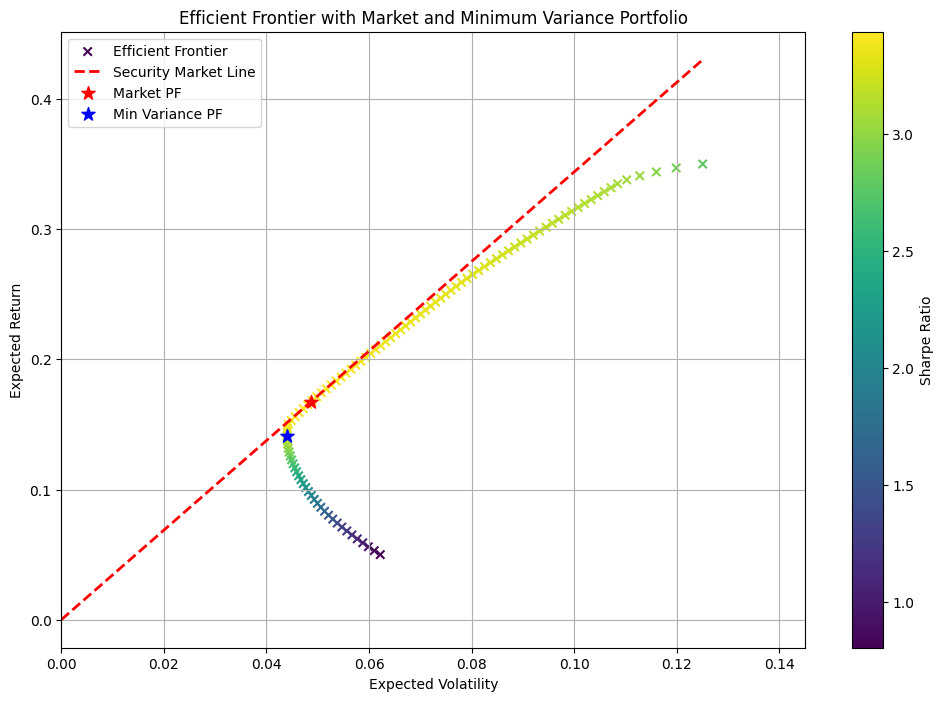

In [36]:
# 그래프 그리기
plt.figure(figsize=(12, 8))
plt.scatter(tvols, trets, c=trets/tvols, marker='x', cmap='viridis', label='Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.plot(sml_x, sml_y, 'r--', linewidth=2, label='Security Market Line')
plt.scatter(market_vol, market_ret, c='red', marker='*', s=100, label='Market PF')
plt.scatter(min_var_vol, min_var_ret, c='blue', marker='*', s=100, label='Min Variance PF')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Market and Minimum Variance Portfolio')
plt.legend()
plt.grid(True)
plt.xlim(0, max(tvols) + 0.02)  # x축 시작을 0부터로 조정
plt.show()

한편 본 노트북에서 직접 구현한 Markowitz Portfolio는 아래와 같이 FnSpace 라이브러리를 활용해 바로 계산할 수도 있습니다. (TBD)

In [ ]:
market_weights, market_ret, market_vol, trets, tvols, tweights = fs.MarkowitzPortfolio(rets, rf=rf, max_weight=0.3)

written by 박재영